# Image processing and analysis for 

## Pulse-shaping based two-photon FRET stoichiometry
### Authors: Daniel C. Flynn, Amar R. Bhagwat, Meredith H. Brenner, Marcos F. Núñez, Briana E. Mork, Dawen Cai, Joel A. Swanson, and Jennifer P. Ogilvie

##### Optics Express Vol. 23, Issue 3, pp. 3353-3372 (2015). https://doi.org/10.1364/OE.23.003353

Image processing code by Amar R. Bhagwat. For the theory see the appendix in the publication.

# Import all the needed Python libraries

In [1]:
# import the needed libraries
import matplotlib.pyplot as plt # basic plotting
from xlrd import open_workbook, cellname # handle excel files
from scipy import ndimage # image manipulation
from scipy import misc # misc. functions related to image handling
import numpy as np # foating point calculation routines
import pylab as P # inline plotting
import pymorph # image manipulation, morphological codes
import mahotas # image manipulation, thresholding etc
import scipy # scientific python routines

# Define all the functions that are called repeatedly

In [2]:
# modules used repeatedly are stored here


def snip_calc(bin_overlap,num_img, denom_img, fig_number):
    """ This function takes in the binary overlap common to the two image files
    being used to calculate a ratio, performs some erosion and restoration operations
    and then uses it to stamp out individual cells as can be distinguished by the 
    algorithm. It can be used for calculating alpha, beta, theta and eta.
    bin_overlap = element-wise product of numerator and denominator image found above 
    threshold
    num_img = image in the numerator of the cross-talk constant
    den_img = image in the denominator of the cross-talk constant"""
    # some image clean up routines for removing small islands 
    bin_erode=ndimage.binary_erosion(bin_overlap, structure=np.ones((2,2)))
    bin_rest=ndimage.binary_propagation(bin_erode, mask=bin_overlap)
    tmp=np.logical_not(bin_rest)
    bin_erode=ndimage.binary_erosion(tmp)
    bin_rest=np.logical_not(ndimage.binary_propagation(bin_erode, mask=tmp))
    #beta_rest=ndimage.binary_closing(beta_erode)
    
    # separate out the distinct unconnected objects
    label_im,nb_labels=ndimage.label(bin_rest)
    # print "number of labels =", nb_labels
    if np.isfinite(fig_number):
        figure(figsize(5,10))
        subplot(1,2,1)
        plt.imshow(label_im)
        subplot(1,2,2)
        plt.imshow(bin_overlap)
        new_fname="alpha_images/cell_pick_%d.png" % fig_number
        savefig(new_fname,bbox_inches='tight')
    
    crs_tlk_array=array([]) # initialize the array to an empty one
    for sl_no in range(nb_labels):
        slice1=ndimage.find_objects(label_im)[sl_no]
        if size(num_img[slice1]) > 350:
            Inum=np.sum(np.multiply(num_img[slice1],bin_rest[slice1]))
            Iden=np.sum(np.multiply(denom_img[slice1],bin_rest[slice1]))
            crs_tlk_array=hstack((crs_tlk_array,np.divide(Inum,Iden)))
    
    return crs_tlk_array

def gamma_calc(bin_overlap,alpha,beta,theta,eta,Id,If,Ia,E):
    """ Read in the cross talk constants, efficiency and FRET images masked 
    for individual cells to calculate gamma using Ia,Id,If"""
    bin_erode=ndimage.binary_erosion(bin_overlap, structure=np.ones((2,2)))
    bin_rest=ndimage.binary_propagation(bin_erode, mask=bin_overlap)
    tmp=np.logical_not(bin_rest)
    bin_erode=ndimage.binary_erosion(tmp)
    bin_rest=np.logical_not(ndimage.binary_propagation(bin_erode, mask=tmp))
    #beta_rest=ndimage.binary_closing(beta_erode)

    label_im,nb_labels=ndimage.label(bin_rest)
    # print "number of labels =", nb_labels
    #figure(figsize(10,20))
    #subplot(1,2,1)
    #plt.imshow(label_im)
    #subplot(1,2,2)
    #plt.imshow(bin_overlap)

    gamma_array=array([])
    for sl_no in range(nb_labels):
        slice1=ndimage.find_objects(label_im)[sl_no]
        if size(bin_rest[slice1]) > 350:
            If_c=np.sum(np.multiply(If[slice1],bin_rest[slice1]))
            Id_c=np.sum(np.multiply(Id[slice1],bin_rest[slice1]))
            Ia_c=np.sum(np.multiply(Ia[slice1],bin_rest[slice1]))
            gamma_array=hstack((gamma_array,E/( ( eta*(If_c-beta*Id_c)/(eta-beta) ) / ( alpha*(theta*Ia_c-If_c)/(theta-alpha) ) -1 ) ))
    
    return gamma_array

def xi_calc(bin_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma):
    """ Read in the cross talk constants, efficiency, gamma and FRET images masked 
    for individual cells to calculate gamma using Ia,Id,If"""
    bin_erode=ndimage.binary_erosion(bin_overlap, structure=np.ones((2,2)))
    bin_rest=ndimage.binary_propagation(bin_erode, mask=bin_overlap)
    tmp=np.logical_not(bin_rest)
    bin_erode=ndimage.binary_erosion(tmp)
    bin_rest=np.logical_not(ndimage.binary_propagation(bin_erode, mask=tmp))
    #beta_rest=ndimage.binary_closing(beta_erode)

    label_im,nb_labels=ndimage.label(bin_rest)
    # print "number of labels =", nb_labels
    #figure(figsize(10,20))
    #subplot(1,2,1)
    #plt.imshow(label_im)
    #subplot(1,2,2)
    #plt.imshow(bin_overlap)

    xi_array=array([])
    for sl_no in range(nb_labels):
        slice1=ndimage.find_objects(label_im)[sl_no]
        if size(bin_rest[slice1]) > 350:
            If_c=np.sum(np.multiply(If[slice1],bin_rest[slice1]))
            Id_c=np.sum(np.multiply(Id[slice1],bin_rest[slice1]))
            Ia_c=np.sum(np.multiply(Ia[slice1],bin_rest[slice1]))
            xi_array=hstack((xi_array,( gamma*E/(1-E)*(eta*Id_c-If_c)/(eta-beta) )/(( (eta*theta-beta*alpha)/((theta-alpha)*(eta-beta)) )*If_c-(eta*beta/(eta-beta))*Id_c-(alpha*theta/(theta-alpha))*Ia_c) ))
    
    return xi_array

## use the cross talk constants, gamma and FRET images masked for individual cells to calculate xi
# using Ia,Id,If

def F_calc(bin_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi):
    """Calculates F_a and F_d using cross-talk constants, efficiency, gamma,
    xi and the images Id, Ia and If. The binary overlap is generated by 
    thresholding and selecting out cells separated from each other. """
    bin_erode=ndimage.binary_erosion(bin_overlap, structure=np.ones((2,2)))
    bin_rest=ndimage.binary_propagation(bin_erode, mask=bin_overlap)
    tmp=np.logical_not(bin_rest)
    bin_erode=ndimage.binary_erosion(tmp)
    bin_rest=np.logical_not(ndimage.binary_propagation(bin_erode, mask=tmp))
    #beta_rest=ndimage.binary_closing(beta_erode)

    label_im,nb_labels=ndimage.label(bin_rest)
    # print "number of labels =", nb_labels
    #figure(figsize(10,20))
    #subplot(1,2,1)
    #plt.imshow(label_im)
    #subplot(1,2,2)
    #plt.imshow(bin_overlap)

    Fa_array=array([])
    Fd_array=array([])
    for sl_no in range(nb_labels):
        slice1=ndimage.find_objects(label_im)[sl_no]
        if size(bin_rest[slice1]) > 350:
            If_c=np.sum(np.multiply(If[slice1],bin_rest[slice1]))
            Id_c=np.sum(np.multiply(Id[slice1],bin_rest[slice1]))
            Ia_c=np.sum(np.multiply(Ia[slice1],bin_rest[slice1]))
            Fd_array=hstack((Fd_array,1/E*(1-((eta*Id_c-If_c)/(eta-beta))/(xi/gamma*((eta*theta-beta*alpha)/((theta-alpha)*(eta-beta))*If_c - eta*beta/(eta-beta)*Id_c - alpha*theta/(theta-alpha)*Ia_c) + (eta*Id_c-If_c)/(eta-beta)))))
            Fa_array=hstack((Fa_array,gamma*( ( eta*(If_c-beta*Id_c)/(eta-beta) ) / ( alpha*(theta*Ia_c-If_c)/(theta-alpha) ) -1 )/E))
    return (Fd_array,Fa_array)

## just calculate the denominator in F_a to see the variation on that

def Fden(bin_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi):

    bin_erode=ndimage.binary_erosion(bin_overlap, structure=np.ones((2,2)))
    bin_rest=ndimage.binary_propagation(bin_erode, mask=bin_overlap)
    tmp=np.logical_not(bin_rest)
    bin_erode=ndimage.binary_erosion(tmp)
    bin_rest=np.logical_not(ndimage.binary_propagation(bin_erode, mask=tmp))
    #beta_rest=ndimage.binary_closing(beta_erode)

    label_im,nb_labels=ndimage.label(bin_rest)
    # print "number of labels =", nb_labels
    #figure(figsize(10,20))
    #subplot(1,2,1)
    #plt.imshow(label_im)
    #subplot(1,2,2)
    #plt.imshow(bin_overlap)

    Fden_array=array([])
    Fnum_array=array([])
    #Fd_array=array([])
    for sl_no in range(nb_labels):
        slice1=ndimage.find_objects(label_im)[sl_no]
        if size(bin_rest[slice1]) > 350:
            If_c=np.sum(np.multiply(If[slice1],bin_rest[slice1]))
            Id_c=np.sum(np.multiply(Id[slice1],bin_rest[slice1]))
            Ia_c=np.sum(np.multiply(Ia[slice1],bin_rest[slice1]))
            #Fd_array=hstack((Fd_array,1/E*(1-((eta*Id_c-If_c)/(eta-beta))/(xi/gamma*((eta*theta-beta*alpha)/((theta-alpha)*(eta-beta))*If_c - eta*beta/(eta-beta)*Id_c - alpha*theta/(theta-alpha)*Ia_c) + (eta*Id_c-If_c)/(eta-beta)))))
            Fden_array=hstack((Fden_array, theta*Ia_c-If_c))
            Fnum_array=hstack((Fnum_array, If_c-beta*Id_c))
    return (Fnum_array,Fden_array)

In [3]:
# string formatting for filenames

# background segments
b_seg1=r'/home/amarb/Work/2014-2-5/SingleImage-02052014-0939-'
b_seg2=r'/SingleImage-02052014-0939-'
# data segments
d_seg1=r'/home/amarb/Work/2014-2-5b/SingleImage-02052014-1149-'
d_seg2=r'/SingleImage-02052014-1149-'

# these segments are common
seg3=r'_Cycle001_CurrentSettings_'
seg4=r'_000001.tif'

In [4]:
# read in and process files for correcting shading and background

# background i_dark average
back3_avg=np.mean(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,37,b_seg2,seg3,'Ch3',seg4)),dtype=float64)
back4_avg=np.mean(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,37,b_seg2,seg3,'Ch4',seg4)),dtype=float64)
#print 'Average background counts for ch3 = ', back3_avg
#print 'Average background counts for ch4 = ', back4_avg

# shading correction for the pulse-shape and channel
sh_am_ch3=np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,33,b_seg2,seg3,'Ch3',seg4)))
sh_am_ch4=np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,33,b_seg2,seg3,'Ch4',seg4)))
sh_td_ch3=np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,35,b_seg2,seg3,'Ch3',seg4)))
sh_td_ch4=np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(b_seg1,35,b_seg2,seg3,'Ch4',seg4)))

# shading correction denoised
sh1_c_am_ch3=ndimage.gaussian_filter(sh_am_ch3-back3_avg,sigma=3)
sh1_c_am_ch4=ndimage.gaussian_filter(sh_am_ch4-back4_avg,sigma=3)
sh1_c_td_ch3=ndimage.gaussian_filter(sh_td_ch3-back3_avg,sigma=3)
sh1_c_td_ch4=ndimage.gaussian_filter(sh_td_ch4-back4_avg,sigma=3)

# normalized shading correction
sh_c_am_ch3=sh1_c_am_ch3/np.max(sh1_c_am_ch3)
sh_c_am_ch4=sh1_c_am_ch4/np.max(sh1_c_am_ch4)
sh_c_td_ch3=sh1_c_td_ch3/np.max(sh1_c_td_ch3)
sh_c_td_ch4=sh1_c_td_ch4/np.max(sh1_c_td_ch4)

# Beta and Theta - Donor-only

Avg beta is  0.242640222836 +- 0.0118707582572
Avg theta is  2.10209839649 +- 0.125620158945


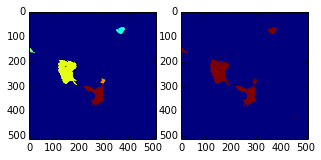

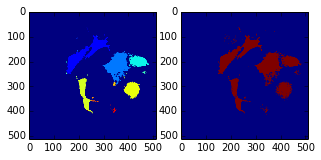

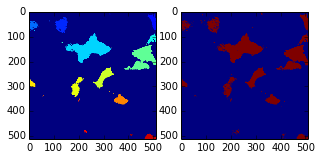

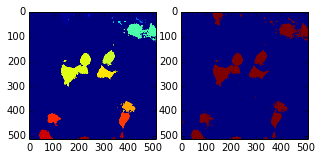

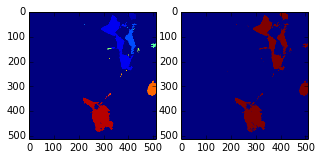

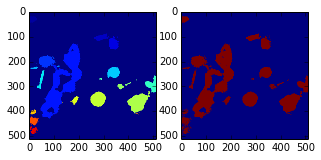

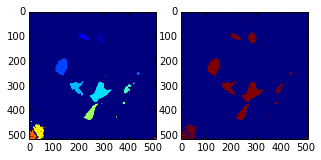

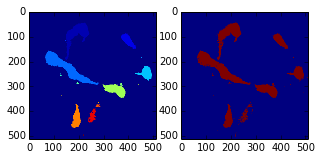

In [5]:
# here we calculate the two cross-talk constants beta and theta defined for Donor only samples

# number of the donor shape and acceptor shape files.
# this is to be derived from the excel file information eventually
fil_list=((41,42),(44,45),(47,48),(50,51),(53,54),(116,117),(119,120),(122,123))

beta_array=array([])
theta_array=array([])
for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    d_ex_d_em=np.divide(donor4,sh_c_am_ch4)
    d_ex_a_em=np.divide(donor3,sh_c_am_ch3)
    a_ex_d_em=np.divide(acc4,sh_c_td_ch4)
    a_ex_a_em=np.divide(acc3,sh_c_td_ch3)
    
    # plt.figure(figsize=(17,12))
    # plt.subplot(2,2,1)
    # P.imshow(d_ex_d_em)
    # plt.title("d exc, d emission")
    # plt.subplot(2,2,2)
    # P.imshow(d_ex_a_em)
    # plt.title("d exc, a emission")
    # plt.subplot(2,2,3)
    # P.imshow(a_ex_d_em)
    # plt.title("a exc, d emission")
    # plt.subplot(2,2,4)
    # P.imshow(a_ex_a_em)
    # plt.title("a exc, a emission")

    ## pixel by pixel division to achieve beta
    # beta=np.divide(d_ex_a_em,d_ex_d_em)
    # theta=np.divide(d_ex_d_em,a_ex_d_em)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(d_ex_d_em.astype(uint16),ignore_zeros=True)
    bin_dd=d_ex_d_em>T
    T=mahotas.otsu(d_ex_a_em.astype(uint16),ignore_zeros=True)
    bin_da=d_ex_a_em>T
    T=mahotas.otsu(a_ex_d_em.astype(uint16),ignore_zeros=True)
    bin_ad=a_ex_d_em>T
    
    # find common pixels that will have cross-talk information
    beta_overlap=np.multiply(bin_dd,bin_da)
    theta_overlap=np.multiply(bin_dd,bin_ad)
    
    beta_array=hstack((beta_array,(snip_calc(beta_overlap,d_ex_a_em,d_ex_d_em,fil_idx))))
    theta_array=hstack((theta_array,(snip_calc(theta_overlap,d_ex_d_em,a_ex_d_em,NaN))))

# print beta_array#), '+-', np.std(beta_array)
# print theta_array#), '+-', np.std(theta_array)
print 'Avg beta is ',np.mean(beta_array), "+-",np.std(beta_array)
print 'Avg theta is ',np.mean(theta_array), "+-",np.std(theta_array)

# Alpha and Eta - Acceptor only

In [6]:
# here we calculate alpha and eta cross-talk constants defined for Acceptor-only samples

# number of the donor shape and acceptor shape files.
# this is to be derived from the excel file information eventually
fil_list=((57,58),(60,61),(63,64),(66,67),(69,70),(72,73),(75,76))

alpha_array=array([])
eta_array=array([])
for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][1]
    acc_file=fil_list[fil_idx][0]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    d_ex_d_em=np.divide(donor4,sh_c_am_ch4)
    d_ex_a_em=np.divide(donor3,sh_c_am_ch3)
    a_ex_d_em=np.divide(acc4,sh_c_td_ch4)
    a_ex_a_em=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(a_ex_a_em.astype(uint16),ignore_zeros=True)
    bin_aa=a_ex_a_em>T
    T=mahotas.otsu(d_ex_a_em.astype(uint16),ignore_zeros=True)
    bin_da=d_ex_a_em>T
    T=mahotas.otsu(a_ex_d_em.astype(uint16),ignore_zeros=True)
    bin_ad=a_ex_d_em>T
    
    # find common pixels that will have cross-talk information
    alpha_overlap=np.multiply(bin_aa,bin_da)
    eta_overlap=np.multiply(bin_aa,bin_ad)
    
    alpha_array=hstack((alpha_array,(snip_calc(alpha_overlap,d_ex_a_em,a_ex_a_em,NaN))))
    eta_array=hstack((eta_array,(snip_calc(eta_overlap,a_ex_a_em,a_ex_d_em,NaN))))

# print alpha_array#), '+-', np.std(beta_array)
# print eta_array#), '+-', np.std(theta_array)
print 'Avg alpha is ',np.mean(alpha_array), "+-",np.std(alpha_array)
print 'Avg eta is ',np.mean(eta_array), "+-",np.std(eta_array)

Avg alpha is  0.349877948713 +- 0.0267967128454
Avg eta is  5.5271403543 +- 0.879438464546


In [7]:
# register mean values of cross-talk constants for further calculations

alpha=np.mean(alpha_array)
print ("cells for alpha =", len(alpha_array))
beta=np.mean(beta_array)
print ("cells for beta =", len(beta_array))
eta=np.mean(eta_array)
print ("cells for eta =", len(eta_array))
theta=np.mean(theta_array)
print ("cells for theta =", len(theta_array))

('cells for alpha =', 28)
('cells for beta =', 74)
('cells for eta =', 29)
('cells for theta =', 66)


# Gamma and Xi - FRET sample only

Avg gamma is  0.403914651582 +- 0.133494439392


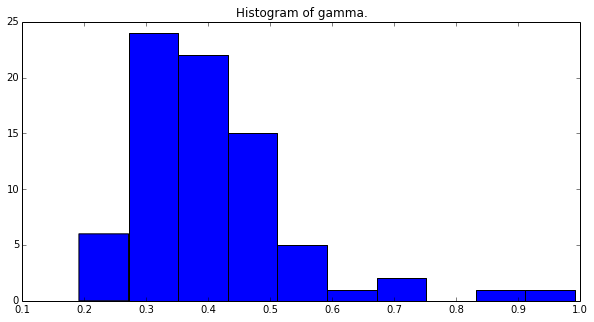

In [8]:
# from the FRET-only sample, we can extract two parameters xi and gamma. Then later use those with unlinked samples to
# check to make sure that we are getting sane results of Fa=0, Fd=0

# first calculate gamma by assuming that Fa=1 for fret only samples
fil_list=((80,81),(85,84),(88,87),(91,90),(94,93),(97,96),(172,171),(175,174),(178,177),(181,180),(184,183))

gamma_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    gamma_array=hstack((gamma_array,(gamma_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E))))
    
# print gamma_array
gamma=np.mean(gamma_array)
print 'Avg gamma is ',gamma,'+-',np.std(gamma_array)
plt.figure(figsize(10,5))
n,bins,patches=P.hist(gamma_array)
plt.title('Histogram of gamma.')
savefig("alpha_images/gamma_hist.png",bbox_inches='tight')

In [9]:
"number of gamma cells=%d" % len(gamma_array)

'number of gamma cells=77'

Avg xi is 0.498131695109 +- 0.160976290687


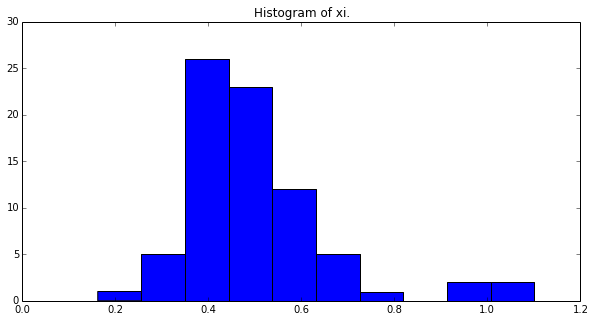

In [10]:
# now calculate xi assuming Fd=1 for fret only samples
fil_list=((80,81),(85,84),(88,87),(91,90),(94,93),(97,96),(172,171),(175,174),(178,177),(181,180),(184,183))

xi_array=array([])
for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    xi_array=hstack((xi_array,(xi_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma))))
    
# print xi_array
xi=np.mean(xi_array)
print 'Avg xi is', xi,'+-',np.std(xi_array)
plt.figure(figsize(10,5))
n,bins,patches=P.hist(xi_array)
plt.title('Histogram of xi.')
savefig("alpha_images/xi_hist.png",bbox_inches='tight')

In [11]:
"number of xi cells=%d" % len(xi_array)

'number of xi cells=77'

# $f_a$ and $f_d$ - linked case only for code sanity

Fa is  1.0907390817 +- 0.313183072483
Fd is  1.04293098569 +- 0.204681357366


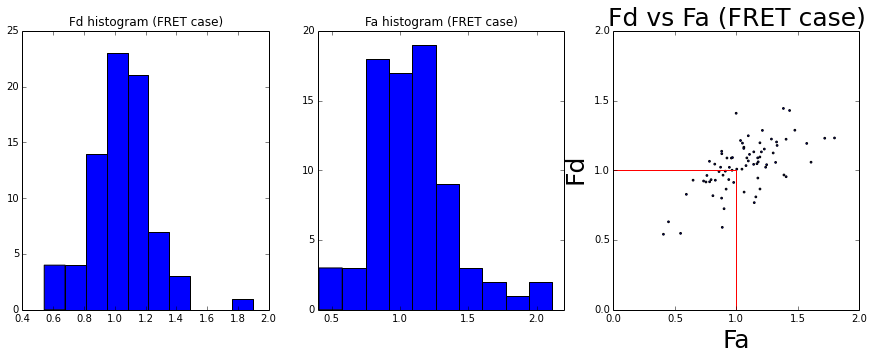

In [15]:
# For Don + Acceptor case where there is no FRET linkage, calculate F_a ad F_d for sanity check
# check to see if they are both close to 0
fil_list=((80,81),(85,84),(88,87),(91,90),(94,93),(97,96),(172,171),(175,174),(178,177),(181,180),(184,183))
# fil_list=((101,102),(104,105),(107,108),(110,111),(113,114))

Fa_array=array([])
Fd_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    F=F_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi)
    Fa_array=hstack((Fa_array,F[1]))
    Fd_array=hstack((Fd_array,F[0]))
# print Fa_array,Fd_array
Fa=np.mean(Fa_array)
Fd=np.mean(Fd_array)
print 'Fa is ',Fa,'+-',np.std(Fa_array)
print 'Fd is ', Fd,'+-',np.std(Fd_array)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
n,bins,patches=P.hist(Fd_array)
plt.title('Fd histogram (FRET case)')
plt.subplot(1,3,2)
n,bins,patches=P.hist(Fa_array)
plt.title('Fa histogram (FRET case)')
plt.subplot(1,3,3)
plt.scatter(Fa_array,Fd_array,s=3)
xlim([0,2])
ylim([0,2])
rect = plt.Rectangle((-1, -1), 2, 2, facecolor="None",edgecolor="Red")
plt.gca().add_patch(rect)
plt.title('Fd vs Fa (FRET case)',size=25)
plt.ylabel('Fd',size=25)
plt.xlabel('Fa',size=25)
savefig("alpha_images/favsfd_FRET.png",bbox_inches='tight')

# $f_a$ and $f_d$ for the unlinked case - for overall sanity check

Fa is  0.000839179683701 +- 0.162581453513
Fd is  -0.0103890051351 +- 0.115125204304


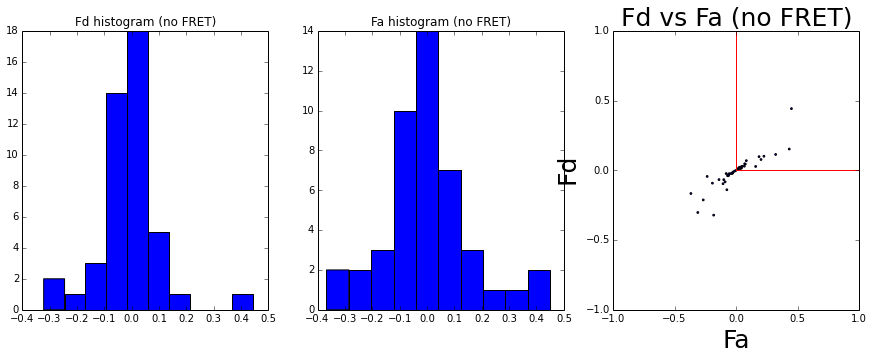

In [18]:
# For Don + Acceptor case where there is no FRET linkage, calculate F_a ad F_d for sanity check
# check to see if they are both close to 0
#fil_list=((80,81),(85,84),(88,87),(91,90),(94,93),(97,96),(172,171),(175,174),(178,177),(181,180),(184,183))
fil_list=((101,102),(104,105),(107,108),(110,111),(113,114))

Fa_array=array([])
Fd_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    F=F_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi)
    Fa_array=hstack((Fa_array,F[1]))
    Fd_array=hstack((Fd_array,F[0]))
# print Fa_array,Fd_array
Fa=np.mean(Fa_array)
Fd=np.mean(Fd_array)
print 'Fa is ',Fa,'+-',np.std(Fa_array)
print 'Fd is ', Fd,'+-',np.std(Fd_array)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
n,bins,patches=P.hist(Fd_array)
plt.title('Fd histogram (no FRET)')
plt.subplot(1,3,2)
n,bins,patches=P.hist(Fa_array)
plt.title('Fa histogram (no FRET)')
plt.subplot(1,3,3)
plt.scatter(Fa_array,Fd_array,s=3)
xlim([-1,1])
ylim([-1,1])
rect = plt.Rectangle((0, 0), 1, 1, facecolor="None",edgecolor="Red")
plt.gca().add_patch(rect)
plt.title('Fd vs Fa (no FRET)',size=25)
plt.ylabel('Fd',size=25)
plt.xlabel('Fa',size=25)
savefig("alpha_images/favsfd_noFRET.png",bbox_inches='tight')

In [33]:
print ('Fa array',len(Fa_array))
print ('Fd array',len(Fd_array))

('Fa array', 45)
('Fd array', 45)


Fa is  0.849230627258 +- 0.348183604039
Fd is  0.171908398005 +- 0.0860966866459


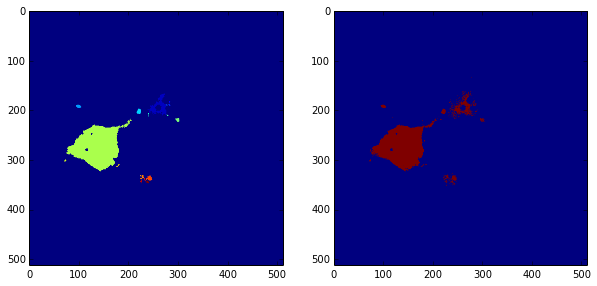

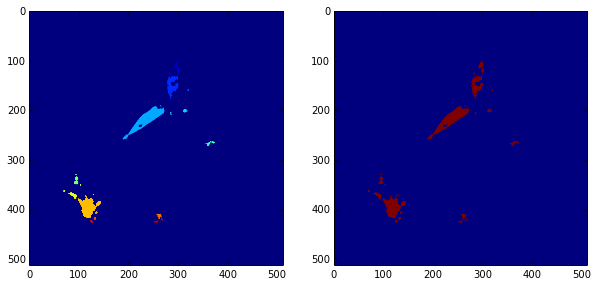

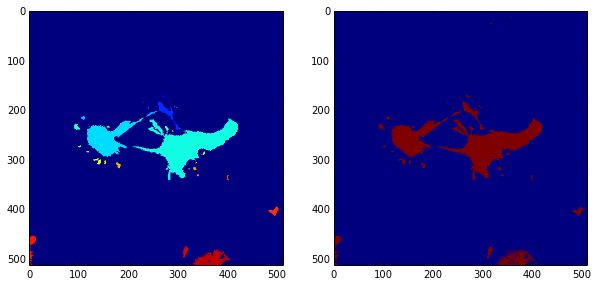

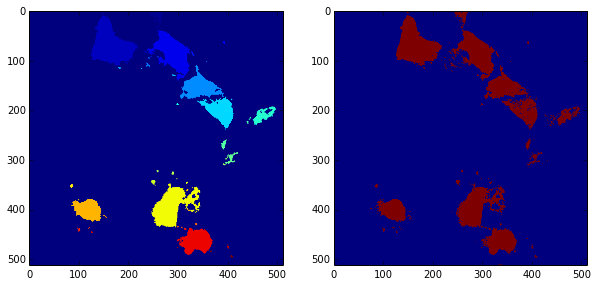

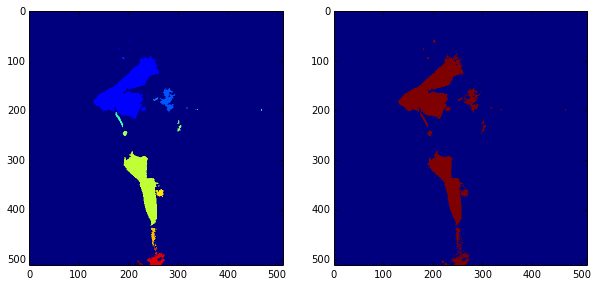

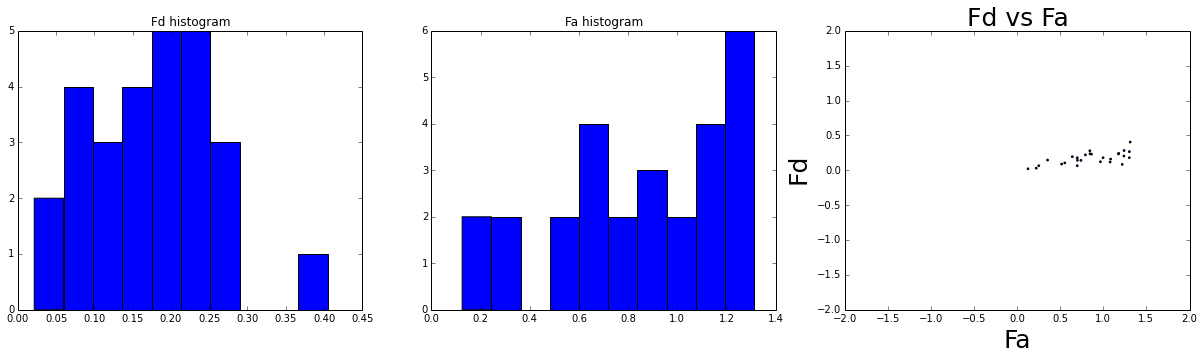

In [12]:
# For FRET + Donor case where there is no FRET linkage, calculate F_a and F_d for sanity check
# check to see if they are both close to 0

fil_list=((125,126),(131,132),(134,135),(137,138),(140,141))

Fa_array=array([])
Fd_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    F=F_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi)
    Fa_array=hstack((Fa_array,F[1]))
    Fd_array=hstack((Fd_array,F[0]))
# print Fa_array,Fd_array
Fa=np.mean(Fa_array)
Fd=np.mean(Fd_array)
print 'Fa is ',Fa,'+-',np.std(Fa_array)
print 'Fd is ', Fd,'+-',np.std(Fd_array)
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
n,bins,patches=P.hist(Fd_array)
plt.title('Fd histogram')
plt.subplot(1,3,2)
n,bins,patches=P.hist(Fa_array)
plt.title('Fa histogram')
plt.subplot(1,3,3)
plt.scatter(Fa_array,Fd_array,s=3)
xlim([-2,2])
ylim([-2,2])
plt.title('Fd vs Fa',size=25)
plt.ylabel('Fd',size=25)
plt.xlabel('Fa',size=25)
plt.show()

Fa is  0.222655235267 +- 0.12100639872
Fd is  0.650697185509 +- 0.25904969003


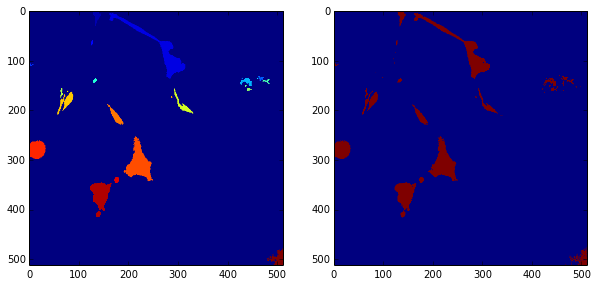

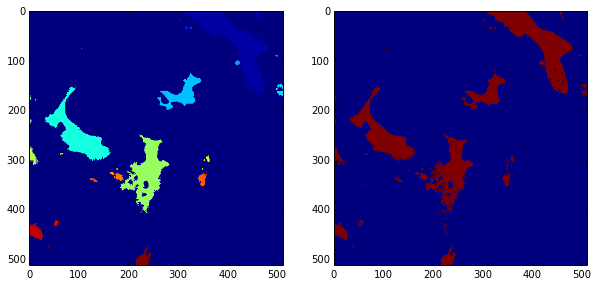

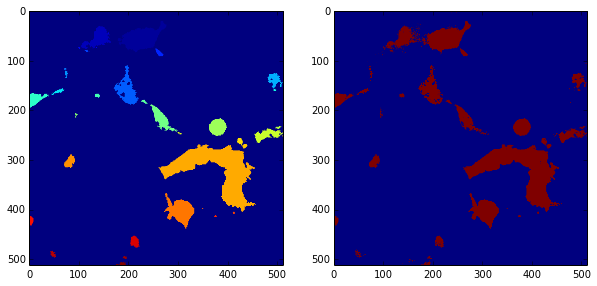

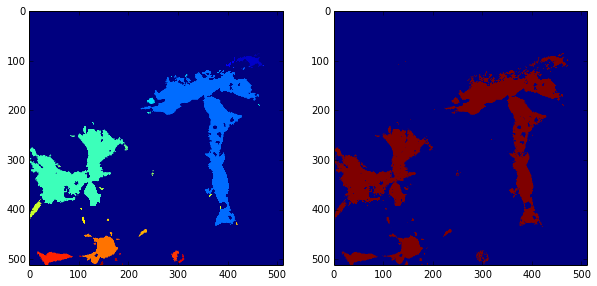

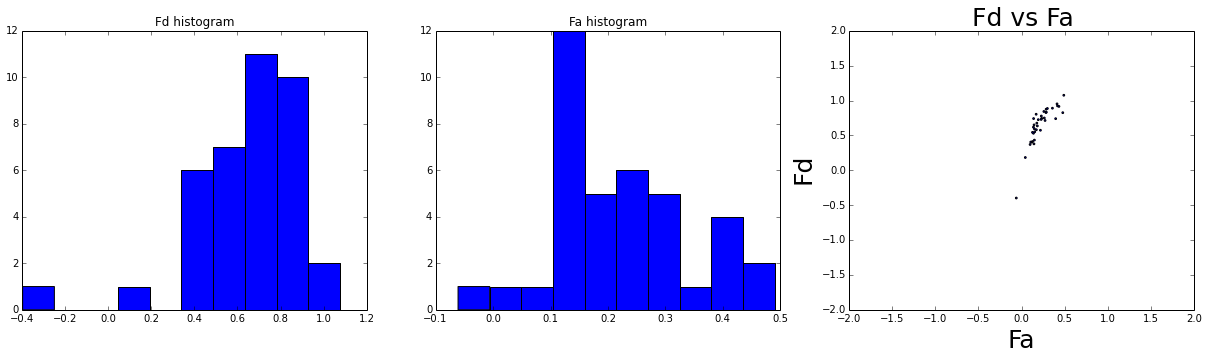

In [13]:
# For FRET + Acceptor case where there is no FRET linkage, calculate F_a ad F_d for sanity check
# check to see if they are both close to 0

fil_list=((143,144),(146,147),(149,150),(152,153))

Fa_array=array([])
Fd_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][1]
    acc_file=fil_list[fil_idx][0]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    F=F_calc(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi)
    Fa_array=hstack((Fa_array,F[1]))
    Fd_array=hstack((Fd_array,F[0]))
# print Fa_array,Fd_array
Fa=np.mean(Fa_array)
Fd=np.mean(Fd_array)
print 'Fa is ',Fa,'+-',np.std(Fa_array)
print 'Fd is ', Fd,'+-',np.std(Fd_array)
plt.figure(figsize=(21,5))
plt.subplot(1,3,1)
n,bins,patches=P.hist(Fd_array)
plt.title('Fd histogram')
plt.subplot(1,3,2)
n,bins,patches=P.hist(Fa_array)
plt.title('Fa histogram')
plt.subplot(1,3,3)
plt.scatter(Fa_array,Fd_array,s=3)
xlim([-2,2])
ylim([-2,2])
plt.title('Fd vs Fa',size=25)
plt.ylabel('Fd',size=25)
plt.xlabel('Fa',size=25)
plt.show()

avg f denominator is 2226707.9316
avg f numerator is 423887.771051


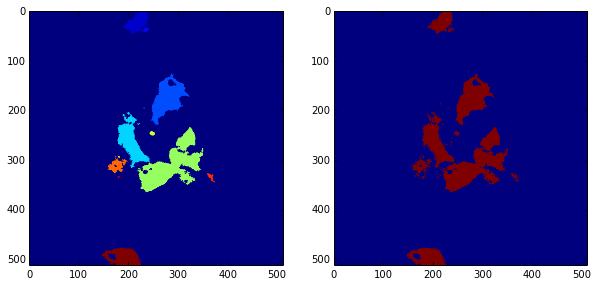

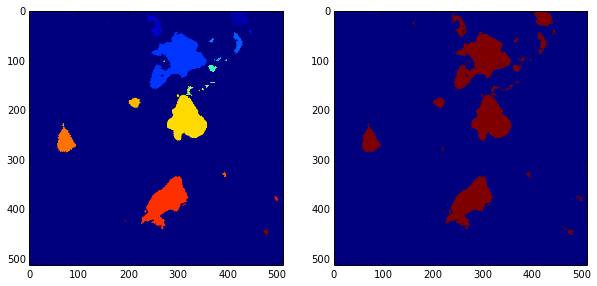

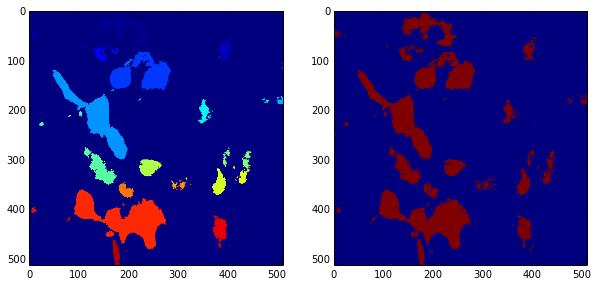

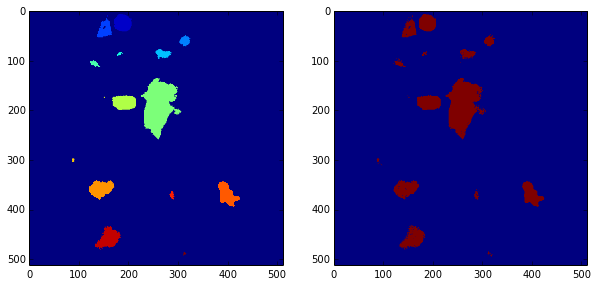

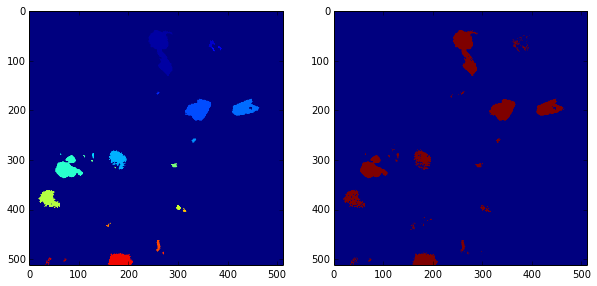

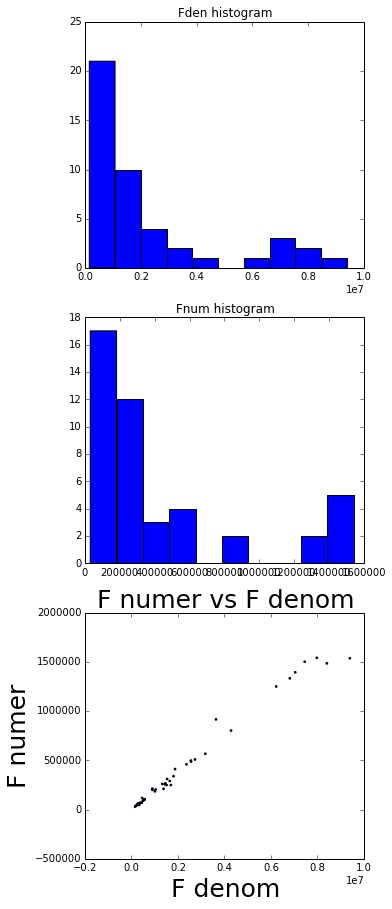

In [14]:
# Just plot the denominator for the F_a case

fil_list=((101,102),(104,105),(107,108),(110,111),(113,114))

Fden_array=array([])
Fnum_array=array([])

for fil_idx in range(len(fil_list)):
    don_file=fil_list[fil_idx][0]
    acc_file=fil_list[fil_idx][1]

    # read in the data from the image files and correct for I_dark, negative values removed
    donor4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    donor3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,don_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)
    #acc4=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch4',seg4)))-back4_avg,0,2500)
    acc3=np.clip(np.double(misc.imread('{0}{1:03d}{2}{1:03d}{3}{4}{5}'.format(d_seg1,acc_file,d_seg2,seg3,'Ch3',seg4)))-back3_avg,0,2500)

    # correct the images for illumination gradient
    Id=np.divide(donor4,sh_c_am_ch4)
    If=np.divide(donor3,sh_c_am_ch3)
    Ia=np.divide(acc3,sh_c_td_ch3)
    
    # calculate where to put thresholds on each of the image files
    # using Otsu's algorithm to split the histogram
    T=mahotas.otsu(Ia.astype(uint16),ignore_zeros=True)
    bin_Ia=Ia>T
    T=mahotas.otsu(If.astype(uint16),ignore_zeros=True)
    bin_If=If>T
    T=mahotas.otsu(Id.astype(uint16),ignore_zeros=True)
    bin_Id=Id>T
    
    # find common pixels that will have cross-talk information
    total_overlap=np.multiply(np.multiply(bin_If,bin_Ia),bin_Id)
    E=0.3
    F=Fden(total_overlap,alpha,beta,theta,eta,Id,If,Ia,E,gamma,xi)
    Fnum_array=hstack((Fnum_array,F[0]))
    Fden_array=hstack((Fden_array,F[1]))
# print Fa_array,Fd_array
#Fa=np.mean(Fa_array)
Fdenom=np.mean(Fden_array)
Fnumer=np.mean(Fnum_array)
print 'avg f denominator is',Fdenom
print 'avg f numerator is',Fnumer
#print 'Fa is ',Fa,'+-',np.std(Fa_array)
#print 'Fd is ', Fd,'+-',np.std(Fd_array)
plt.figure(figsize=(5,15))
plt.subplot(3,1,1)
n,bins,patches=P.hist(Fden_array,bins=10)
plt.title('Fden histogram')
plt.subplot(3,1,2)
n,bins,patches=P.hist(Fnum_array, bins=10)
plt.title('Fnum histogram')
plt.subplot(3,1,3)
plt.scatter(Fden_array,Fnum_array,s=3)
#xlim([-1,1])
#ylim([-1,1])
plt.title('F numer vs F denom',size=25)
plt.ylabel('F numer',size=25)
plt.xlabel('F denom',size=25)
plt.show()